In [1425]:
# imports
import sys
import os
import socket
import pandas as pd
import glob
from datetime import datetime
import numpy as np
import sklearn
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, roc_auc_score, log_loss, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from mlxtend.feature_selection import ColumnSelector
import lightgbm
from lightgbm import LGBMClassifier, plot_importance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#turn off warning
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#set random state (this can be done manually to reproduce results)
random_state = np.random.randint(1000000)
#random_state = 563039
print(random_state)

# set target column
target_col = 'late_dx'

442609


In [1426]:
# these are toggles to run notebook with different parameters
use_hes_dx = True
use_e_pracid = True
use_binned_age = True
use_sum_xm = True

In [1427]:
# these are strings dependent on above toggles to add to output file names for reference
if use_hes_dx:
    hes = 'incl_hes_dx'
else:
    hes = 'excl_hes_dx'

if use_e_pracid:
    pr_id = 'incl_e_pracid'
else:
    pr_id = 'excl_e_pracid'
    
if use_binned_age:
    bin_age = 'bin_age'
else:
    bin_age = 'cont_age'
    
if use_sum_xm:
    sum_xm = 'sum_xm'
else:
    sum_xm = 'not_sum_xm'

In [1428]:
# read in cohort file
cohort_in = pd.read_parquet(os.getcwd() + '/cohort_with_risk_factors.parquet')

In [1429]:
cohort_in.age_at_dx.isna().sum()

0

In [1430]:
cohort_in.e2015_imd_5.isna().sum()

91

In [1431]:
cohort_in.gender.isna().sum()

0

In [1432]:
# drop nans from practice depravation column as not many
cohort_in = cohort_in.dropna(subset=['e2015_imd_5'])
# add column for total number of multimorbidities
cohort_in['multimorbidities'] = cohort_in.iloc[:,-11:-1].sum(axis=1)
# add column for years of up to standard data
cohort_in['years_uts_to_dx'] = cohort_in.first_diagnosis_date.dt.year - cohort_in.uts.dt.year
# add a categorical age_at_dx diagnosis with bins
cohort_in['binned_age_at_dx'] = pd.cut(x=cohort_in.age_at_dx, bins=[35, 50, 65, 80, 95, 110],
                                       labels=['35-50', '50-65', '65-80', '80-95', '95-110'])
cohort_in.head()

,e_patid,first_diagnosis_date,first_diagnosed_in_primary_care,gender,age_at_dx,e_pracid,region,uts,e2015_imd_5,dx_minus6m,dx_minus12m,dx_minus18m,dx_minus24m,dx_minus3y,dx_minus5y,late_dx,Ethnicity,drinking_status,weight_category,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities,years_uts_to_dx,binned_age_at_dx
0,24117254,2005-10-04,1.0,1.0,70.0,54.0,10.0,2000-01-12,4.0,2005-04-04,2004-10-04,2004-04-04,2003-10-05,2002-10-05,2000-10-04,0.0,White,Current drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,65-80
1,519045131,2004-02-11,0.0,1.0,74.0,131.0,2.0,1992-12-21,5.0,2003-08-12,2003-02-11,2002-08-12,2002-02-11,2001-02-11,1999-02-11,1.0,White,Current drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,65-80
2,734003216,2009-08-26,1.0,2.0,93.0,216.0,10.0,2003-02-14,4.0,2009-02-24,2008-08-26,2008-02-25,2007-08-27,2006-08-27,2004-08-26,0.0,White,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6,80-95
3,10485798,2014-01-02,0.0,1.0,89.0,98.0,6.0,1990-01-03,4.0,2013-07-03,2013-01-02,2012-07-03,2012-01-03,2011-01-03,2009-01-02,1.0,White,Ex drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,24,80-95
4,630194220,2003-05-15,0.0,2.0,74.0,220.0,7.0,1997-09-23,5.0,2002-11-13,2002-05-15,2001-11-13,2001-05-15,2000-05-15,1998-05-15,1.0,White,Current drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6,65-80


In [1433]:
# remove hes diagnosis patients if selected
if not use_hes_dx:
    cohort_in = cohort_in[cohort_in.first_diagnosed_in_primary_care == 1.0]

In [1434]:
cohort = cohort_in.copy(deep=True)
cohort.head()

,e_patid,first_diagnosis_date,first_diagnosed_in_primary_care,gender,age_at_dx,e_pracid,region,uts,e2015_imd_5,dx_minus6m,dx_minus12m,dx_minus18m,dx_minus24m,dx_minus3y,dx_minus5y,late_dx,Ethnicity,drinking_status,weight_category,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities,years_uts_to_dx,binned_age_at_dx
0,24117254,2005-10-04,1.0,1.0,70.0,54.0,10.0,2000-01-12,4.0,2005-04-04,2004-10-04,2004-04-04,2003-10-05,2002-10-05,2000-10-04,0.0,White,Current drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,65-80
1,519045131,2004-02-11,0.0,1.0,74.0,131.0,2.0,1992-12-21,5.0,2003-08-12,2003-02-11,2002-08-12,2002-02-11,2001-02-11,1999-02-11,1.0,White,Current drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,65-80
2,734003216,2009-08-26,1.0,2.0,93.0,216.0,10.0,2003-02-14,4.0,2009-02-24,2008-08-26,2008-02-25,2007-08-27,2006-08-27,2004-08-26,0.0,White,None,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6,80-95
3,10485798,2014-01-02,0.0,1.0,89.0,98.0,6.0,1990-01-03,4.0,2013-07-03,2013-01-02,2012-07-03,2012-01-03,2011-01-03,2009-01-02,1.0,White,Ex drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,24,80-95
4,630194220,2003-05-15,0.0,2.0,74.0,220.0,7.0,1997-09-23,5.0,2002-11-13,2002-05-15,2001-11-13,2001-05-15,2000-05-15,1998-05-15,1.0,White,Current drinker,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6,65-80


In [1435]:
# essentially make gender a one hot categorical (binary) for male gender as no non-male or female genders present in cohort
cohort.gender = cohort.gender.replace(to_replace=2.0, value=0.0)

In [1436]:
# replace None or NaN values for categoricals with Unspecified
cohort.Ethnicity = cohort.Ethnicity.replace([None], value='Unspecified')
cohort.weight_category = cohort.weight_category.replace([None], value='Unspecified')
cohort.drinking_status = cohort.drinking_status.replace([None], value='Unspecified')
cohort.head()

,e_patid,first_diagnosis_date,first_diagnosed_in_primary_care,gender,age_at_dx,e_pracid,region,uts,e2015_imd_5,dx_minus6m,dx_minus12m,dx_minus18m,dx_minus24m,dx_minus3y,dx_minus5y,late_dx,Ethnicity,drinking_status,weight_category,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities,years_uts_to_dx,binned_age_at_dx
0,24117254,2005-10-04,1.0,1.0,70.0,54.0,10.0,2000-01-12,4.0,2005-04-04,2004-10-04,2004-04-04,2003-10-05,2002-10-05,2000-10-04,0.0,White,Current drinker,Unspecified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,65-80
1,519045131,2004-02-11,0.0,1.0,74.0,131.0,2.0,1992-12-21,5.0,2003-08-12,2003-02-11,2002-08-12,2002-02-11,2001-02-11,1999-02-11,1.0,White,Current drinker,Unspecified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,65-80
2,734003216,2009-08-26,1.0,0.0,93.0,216.0,10.0,2003-02-14,4.0,2009-02-24,2008-08-26,2008-02-25,2007-08-27,2006-08-27,2004-08-26,0.0,White,Unspecified,Unspecified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6,80-95
3,10485798,2014-01-02,0.0,1.0,89.0,98.0,6.0,1990-01-03,4.0,2013-07-03,2013-01-02,2012-07-03,2012-01-03,2011-01-03,2009-01-02,1.0,White,Ex drinker,Unspecified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,24,80-95
4,630194220,2003-05-15,0.0,0.0,74.0,220.0,7.0,1997-09-23,5.0,2002-11-13,2002-05-15,2001-11-13,2001-05-15,2000-05-15,1998-05-15,1.0,White,Current drinker,Unspecified,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6,65-80


In [1437]:
print(cohort.shape[0])
print(cohort.Ethnicity.value_counts())
print(cohort.weight_category.value_counts())
print(cohort.drinking_status.value_counts())

20693
White      20166
Black        158
Other        130
Mixed        123
S_Asian      116
Name: Ethnicity, dtype: int64
Unspecified       18885
Obese              1139
Healthy weight      327
Underweight         211
Overweight          131
Name: weight_category, dtype: int64
Current drinker    10226
Unspecified         5692
Non drinker         2552
Ex drinker          2223
Name: drinking_status, dtype: int64


In [1438]:
# Get mean and median age at diagnosis and range, gender split, median registration length from describe
# output cohort descriptive stats to csv file
cohort.describe().to_csv(os.getcwd() + '/Analysis Outputs' + f'/{hes}_describe.csv')
cohort.describe()

,e_patid,first_diagnosed_in_primary_care,gender,age_at_dx,e_pracid,region,e2015_imd_5,late_dx,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities,years_uts_to_dx
count,2.069300e+04,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000,20693.000000
mean,2.723381e+08,0.451892,0.364423,80.180158,133.819794,6.208331,3.323829,0.716184,0.091722,0.023341,0.024501,0.094573,0.004156,0.168414,0.056638,0.505968,0.096264,0.174842,0.064949,1.240419,13.068574
std,2.545249e+08,0.497692,0.481280,8.260225,75.053177,2.598298,1.374054,0.450859,0.288640,0.150988,0.154602,0.292631,0.064334,0.374243,0.231154,0.499976,0.294961,0.379841,0.246443,1.083167,6.282371
min,2.888000e+03,0.000000,0.000000,45.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.522714e+07,0.000000,0.000000,75.000000,70.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
50%,1.845892e+08,0.000000,0.000000,81.000000,137.000000,7.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,13.000000
75%,4.912852e+08,1.000000,1.000000,86.000000,201.000000,8.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,17.000000
max,7.997942e+08,1.000000,1.000000,106.000000,257.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,31.000000


In [1439]:
# categorical column describe equivalent to get descriptive stats
cohort.Ethnicity.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_ethnicity_stats.csv')
cohort.drinking_status.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_drinking_status_stats.csv')
cohort.weight_category.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_weight_category_stats.csv')
cohort.binned_age_at_dx.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_binned_age_stats.csv')

In [1440]:
# output cohort late dx descriptive stats to csv file
cohort[cohort.late_dx == 1.0].describe().to_csv(os.getcwd() + '/Analysis Outputs' 
                                                + f'/{hes}_late_dx_describe.csv')
cohort[cohort.late_dx == 1.0].describe()

,e_patid,first_diagnosed_in_primary_care,gender,age_at_dx,e_pracid,region,e2015_imd_5,late_dx,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities,years_uts_to_dx
count,1.482000e+04,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.0,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.0000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,2.709165e+08,0.234683,0.362348,80.633401,133.072672,6.151282,3.344265,1.0,0.097099,0.026788,0.027328,0.098178,0.004858,0.1861,0.060864,0.519703,0.100472,0.183198,0.070040,1.304588,13.797638
std,2.540913e+08,0.423815,0.480695,8.170807,75.107932,2.622411,1.371914,0.0,0.296102,0.161469,0.163043,0.297565,0.069534,0.3892,0.239088,0.499628,0.300639,0.386842,0.255224,1.101719,6.314732
min,2.888000e+03,0.000000,0.000000,49.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.465402e+07,0.000000,0.000000,75.000000,70.000000,4.000000,2.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
50%,1.821772e+08,0.000000,0.000000,81.000000,135.000000,7.000000,4.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,14.000000
75%,4.899566e+08,0.000000,1.000000,86.000000,199.000000,8.000000,5.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,18.000000
max,7.997942e+08,1.000000,1.000000,106.000000,257.000000,10.000000,5.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,31.000000


In [1441]:
# categorical column describe equivalent to get late dx descriptive stats
cohort[cohort.late_dx == 1.0].Ethnicity.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_late_dx_ethnicity_stats.csv')
cohort[cohort.late_dx == 1.0].drinking_status.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_late_dx_drinking_status_stats.csv')
cohort[cohort.late_dx == 1.0].weight_category.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_late_dx_weight_category_stats.csv')
cohort[cohort.late_dx == 1.0].binned_age_at_dx.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_late_binned_age_stats.csv')

In [1442]:
# output cohort timely dx descriptive stats to csv file
cohort[cohort.late_dx != 1.0].describe().to_csv(os.getcwd() + '/Analysis Outputs' 
                                                + f'/{hes}_timely_dx_describe.csv')
cohort[cohort.late_dx != 1.0].describe()

,e_patid,first_diagnosed_in_primary_care,gender,age_at_dx,e_pracid,region,e2015_imd_5,late_dx,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities,years_uts_to_dx
count,5.873000e+03,5873.0,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.0,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000
mean,2.759252e+08,1.0,0.369658,79.036438,135.705091,6.352290,3.272263,0.0,0.078154,0.014643,0.017368,0.085476,0.002384,0.123787,0.045973,0.471309,0.085646,0.153754,0.052103,1.078495,11.228844
std,2.556021e+08,0.0,0.482753,8.374008,74.888083,2.530943,1.378210,0.0,0.268437,0.120130,0.130648,0.279612,0.048770,0.329366,0.209445,0.499219,0.279865,0.360744,0.222253,1.017123,5.806843
min,9.987000e+03,1.0,0.000000,45.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4.635842e+07,1.0,0.000000,73.000000,70.000000,5.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
50%,1.905602e+08,1.0,0.000000,79.000000,139.000000,7.000000,3.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000
75%,4.957122e+08,1.0,1.000000,85.000000,206.000000,8.000000,4.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,15.000000
max,7.997262e+08,1.0,1.000000,105.000000,257.000000,10.000000,5.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000


In [1443]:
# categorical column describe equivalent to get late dx descriptive stats
cohort[cohort.late_dx != 1.0].Ethnicity.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_timely_dx_ethnicity_stats.csv')
cohort[cohort.late_dx != 1.0].drinking_status.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_timely_dx_drinking_status_stats.csv')
cohort[cohort.late_dx != 1.0].weight_category.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_timely_dx_weight_category_stats.csv')
cohort[cohort.late_dx != 1.0].binned_age_at_dx.value_counts(normalize=True).to_csv(
    os.getcwd() + '/Analysis Outputs' + f'/{hes}_timely_binned_age_stats.csv')

In [1383]:
# remove e_pracid and replace age as binned age as selected column if toggle set to false
if use_binned_age:
    age_col = 'binned_age_at_dx'
else:
    age_col = 'age_at_dx'

if use_e_pracid:
    supported_cols = ['drinking_status', 'weight_category', 'Ethnicity', 'e2015_imd_5', 'e_pracid', age_col, 
                      'gender', 'anxiety_or_depression_in_last_3y', 'smi', 'epilepsy', 'asthma', 'cfs', 'ckd', 
                      'copd', 'hypertension', 'osteoporosis', 'chd', 'heart_failure']
else:
    supported_cols = ['drinking_status', 'weight_category', 'Ethnicity', 'e2015_imd_5', age_col, 
                      'gender', 'anxiety_or_depression_in_last_3y', 'smi', 'epilepsy', 'asthma', 'cfs', 'ckd', 
                      'copd', 'hypertension', 'osteoporosis', 'chd', 'heart_failure']

# e_pracid column selection for pipeline
if use_e_pracid and use_binned_age:
    num_cutoff = 6
elif use_e_pracid or use_binned_age:
    num_cutoff = 5
else:
    num_cutoff = 4

# if use sum of multimorbidities add as column last
if use_sum_xm:
    supported_cols.append('multimorbidities')

In [1387]:
# create numerical pipeline scaling the age at dx only to a standard scaler
if not use_binned_age:
    numerical_pipeline = Pipeline(steps=[
        ("converter", FunctionTransformer(lambda df: df.apply(pd.to_numeric, errors="coerce"))),
        ('standardizer', StandardScaler())
    ])
    
    numerical_transformers = [('numerical', numerical_pipeline, [supported_cols[num_cutoff]])]

In [1388]:
# one hot encode categorical variables ethnicity, weight category, alcohol use, practice depravity pentile
# also one hot encode practice id if included
one_hot_pipeline = Pipeline(steps=[
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

categorical_one_hot_transformers = [('onehot', one_hot_pipeline, supported_cols[:num_cutoff])]

In [1389]:
# combine as one pipeline and pass through already one hot categorical variables
if not use_binned_age:
    transformers = categorical_one_hot_transformers + numerical_transformers
else:
    transformers = categorical_one_hot_transformers

preprocessor = ColumnTransformer(transformers, remainder='passthrough', sparse_threshold=0)

In [1390]:
# create test train split as 80:20
train, test = np.split(cohort.sample(frac=1, random_state=random_state), [int(.8*cohort.shape[0])])

X_train = train[supported_cols]
y_train = train[target_col]

X_test = test[supported_cols]
y_test = test[target_col]

X_train.head()

,drinking_status,weight_category,Ethnicity,e2015_imd_5,e_pracid,binned_age_at_dx,gender,anxiety_or_depression_in_last_3y,smi,epilepsy,asthma,cfs,ckd,copd,hypertension,osteoporosis,chd,heart_failure,multimorbidities
15571,Current drinker,Unspecified,White,4.0,149.0,80-95,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0
189,Non drinker,Unspecified,White,1.0,60.0,80-95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11011,Current drinker,Underweight,White,5.0,235.0,65-80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0
17320,Ex drinker,Unspecified,White,4.0,115.0,80-95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
6586,Current drinker,Unspecified,White,5.0,246.0,80-95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [1391]:
# choose lgbm model type
lgbm_model = LGBMClassifier(random_state=random_state)

In [1392]:
# create lgbm model pipeline
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model)
])

# Create a separate pipeline to transform the validation dataset. This is used for early stopping.
pipeline_val = Pipeline([
    ('preprocessor', preprocessor)
])

In [1393]:
# specify Stratified K fold method
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# cross validate lgbm model parameters maximising for ROC-AUC
# partially based on https://www.kaggle.com/c0conuts/xgb-k-folds-fastai-pca
max_auc = 0
predicts = []
for train_index, test_index in kf.split(X_train, y_train):
    print("###")
    X_t, X_v = X_train.iloc[train_index], X_train.iloc[test_index]
    y_t, y_v = y_train.iloc[train_index], y_train.iloc[test_index]
    pipeline_val.fit(X_t, y_t)
    X_v_processed = pipeline_val.transform(X_v)
    
    lgbm_pipeline.fit(X_t, y_t, classifier__eval_metric='AUC',
                      classifier__callbacks=[lightgbm.early_stopping(5), lightgbm.log_evaluation(0)],
                      classifier__eval_set=[(X_v_processed,y_v)])
    auc = max(lgbm_pipeline.named_steps["classifier"].evals_result_['valid_0']['auc'])
    if auc > max_auc:
        predicts = lgbm_pipeline.predict_proba(X_test)
        max_auc = auc

###
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[37]	valid_0's auc: 0.66002	valid_0's binary_logloss: 0.563436
###
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[47]	valid_0's auc: 0.639956	valid_0's binary_logloss: 0.575122
###
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[33]	valid_0's auc: 0.678181	valid_0's binary_logloss: 0.554902
###
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.629467	valid_0's binary_logloss: 0.58115
###
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[39]	valid_0's auc: 0.662647	valid_0's binary_logloss: 0.559524
###
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[2]	valid_0's auc: 0.656912	valid_0's binary_logloss: 0.5868
###
Training until validatio

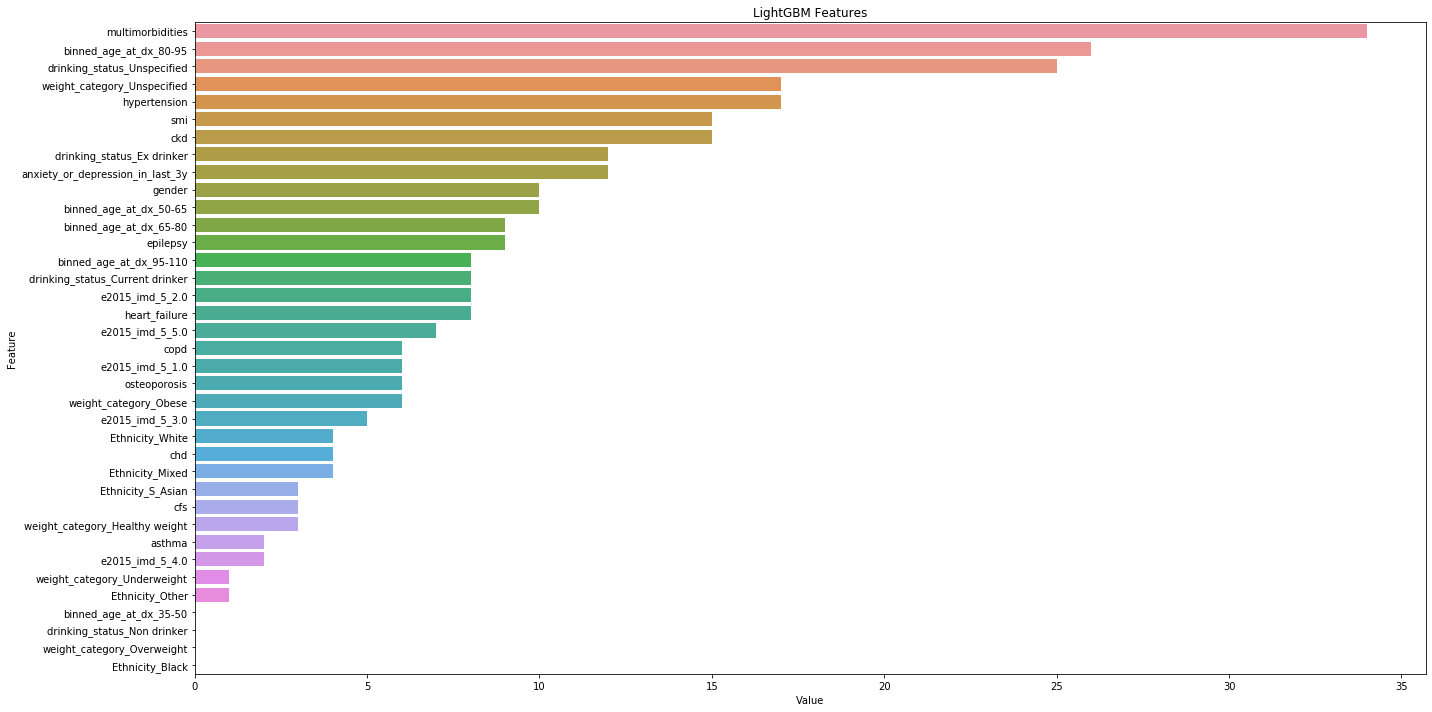

In [1394]:
# Get the names of each feature
feature_names = list(lgbm_pipeline.named_steps[
    "preprocessor"].named_transformers_[
    "onehot"].named_steps[
    "one_hot_encoder"].get_feature_names_out()) + supported_cols[num_cutoff:]
# Get the coefficients of each feature
feature_importances = lgbm_pipeline.named_steps["classifier"].feature_importances_

feature_imp = pd.DataFrame(sorted(zip(feature_importances,feature_names)), columns=['Value','Feature']).sort_values(
    by="Value", ascending=False)

#plot non practice id feature importances and save plot
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp[~feature_imp.Feature.str.contains('e_pracid')])
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig(os.getcwd() + '/Analysis Outputs/Plot pngs' +
            f'/lgbm_{hes}_{pr_id}_{bin_age}_{sum_xm}_importances-rand_state{random_state}.png')
plt.show()

In [1395]:
# output non practice id feature importances as a csv
feature_imp[~feature_imp.Feature.str.contains('e_pracid')].sort_values(by="Value", ascending=False)
feature_imp[~feature_imp.Feature.str.contains('e_pracid')].to_csv(
    os.getcwd() + '/Analysis Outputs/Importance csvs'
    + f'/lgbm_{hes}_{pr_id}_{bin_age}_{sum_xm}_importances-rand_state{random_state}.csv')

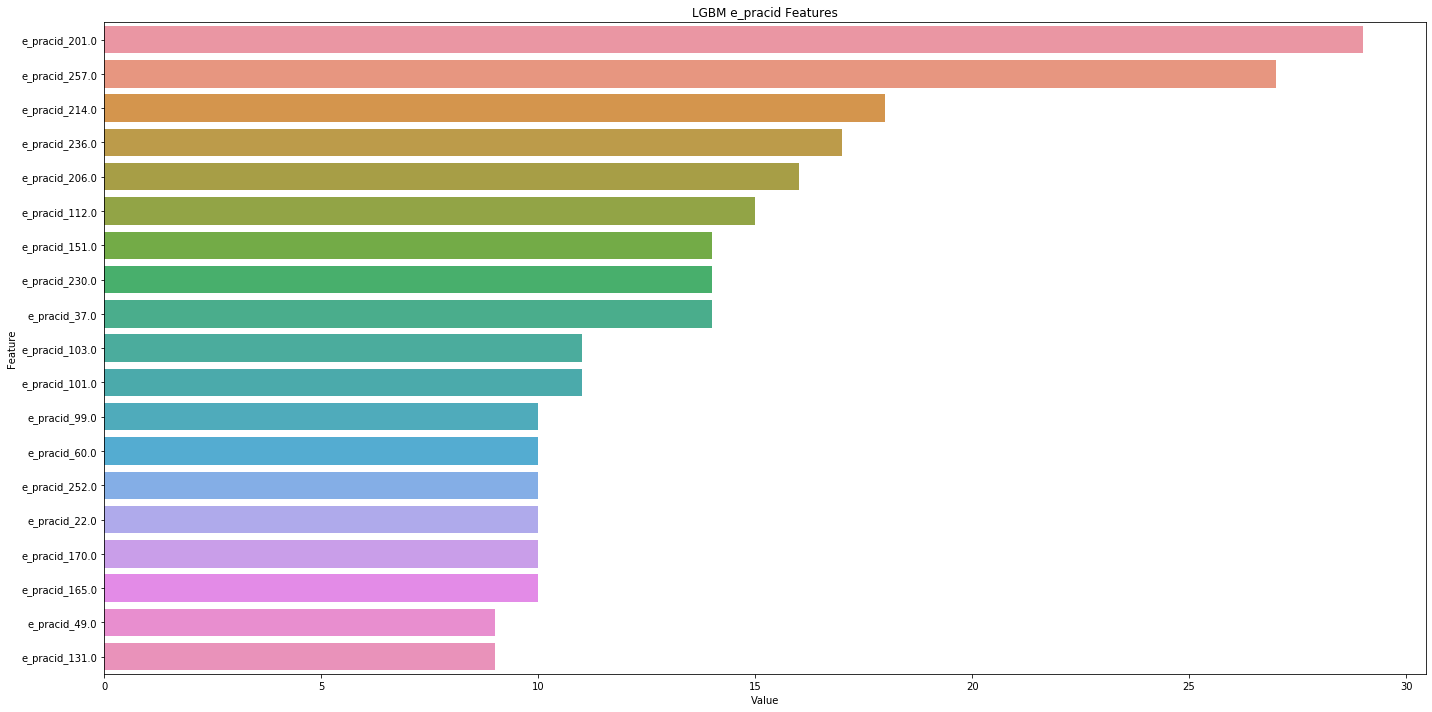

In [1396]:
# plot and save plot for top 10% most important practice id features if selected
if use_e_pracid:
    plt.figure(figsize=(20, 10))
    plot_data = feature_imp[feature_imp.Feature.str.contains('e_pracid')]
    plot_data = plot_data[abs(plot_data.Value) > plot_data.Value.quantile(.9)]
    sns.barplot(x="Value", y="Feature", data=plot_data)
    plt.title('LGBM e_pracid Features')
    plt.tight_layout()
    plt.savefig(os.getcwd() + '/Analysis Outputs/Plot pngs' +
                f'/lgbm_{hes}_{pr_id}_{bin_age}_{sum_xm}_e_pracid_importances-rand_state{random_state}.png')
    plt.show()

In [1397]:
# output csv for top 10% most important practice id feature importances
if use_e_pracid:
    feature_imp[feature_imp.Feature.str.contains('e_pracid')].sort_values(by="Value", ascending=False)
    feature_imp[feature_imp.Feature.str.contains('e_pracid')].to_csv(
        os.getcwd() + '/Analysis Outputs/Importance csvs'
        + f'/lgbm_{hes}_{pr_id}_{bin_age}_{sum_xm}_e_pracid_importances-rand_state{random_state}.csv')

In [1398]:
# output for classifier is a 2d array with the predicted probabilities p and q = (1 - p), we want p
test_preds = predicts[:,1]

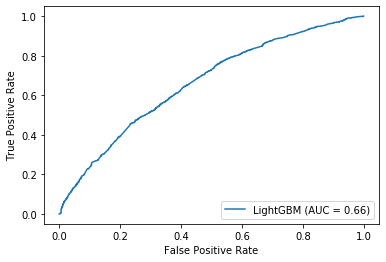

In [1399]:
#create ROC curve
fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = roc_auc_score(y_test, test_preds)

plt.plot(fpr,tpr)
plt.legend([f'LightGBM (AUC = {np.round(roc_auc, 2)})'], loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plot and save plot for lgbm best params roc auc score
plt.savefig(os.getcwd() + '/Analysis Outputs/Plot pngs' +
            f'/lgbm_{hes}_{pr_id}_{bin_age}_{sum_xm}_roc-rand_state{random_state}.png')
plt.show()

In [1400]:
# create logistic regression pipeline
lr_model = LogisticRegression(max_iter=1000, random_state=random_state)
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lr_model)
])

lr_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

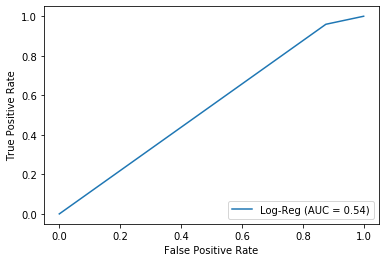

In [1401]:
# use grid search cv for cross validation of parameters
grid_vals = {'classifier__penalty': ['l2'], 'classifier__C': [0.0001,0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=lr_pipeline, param_grid=grid_vals, scoring='roc_auc', 
                       cv=kf, refit=True, return_train_score=True) 

#Training and Prediction

grid_lr.fit(X_train, y_train)
test_preds = grid_lr.best_estimator_.predict(X_test)

#create ROC curve
fpr, tpr, _ = roc_curve(y_test, test_preds)
roc_auc = roc_auc_score(y_test, test_preds)
plt.plot(fpr,tpr)
plt.legend([f'Log-Reg (AUC = {np.round(roc_auc, 2)})'], loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# save and plot roc auc curve
plt.savefig(os.getcwd() + '/Analysis Outputs/Plot pngs' +
            f'/log-reg_{hes}_{pr_id}_{bin_age}_{sum_xm}_roc-rand_state{random_state}.png')
plt.show()

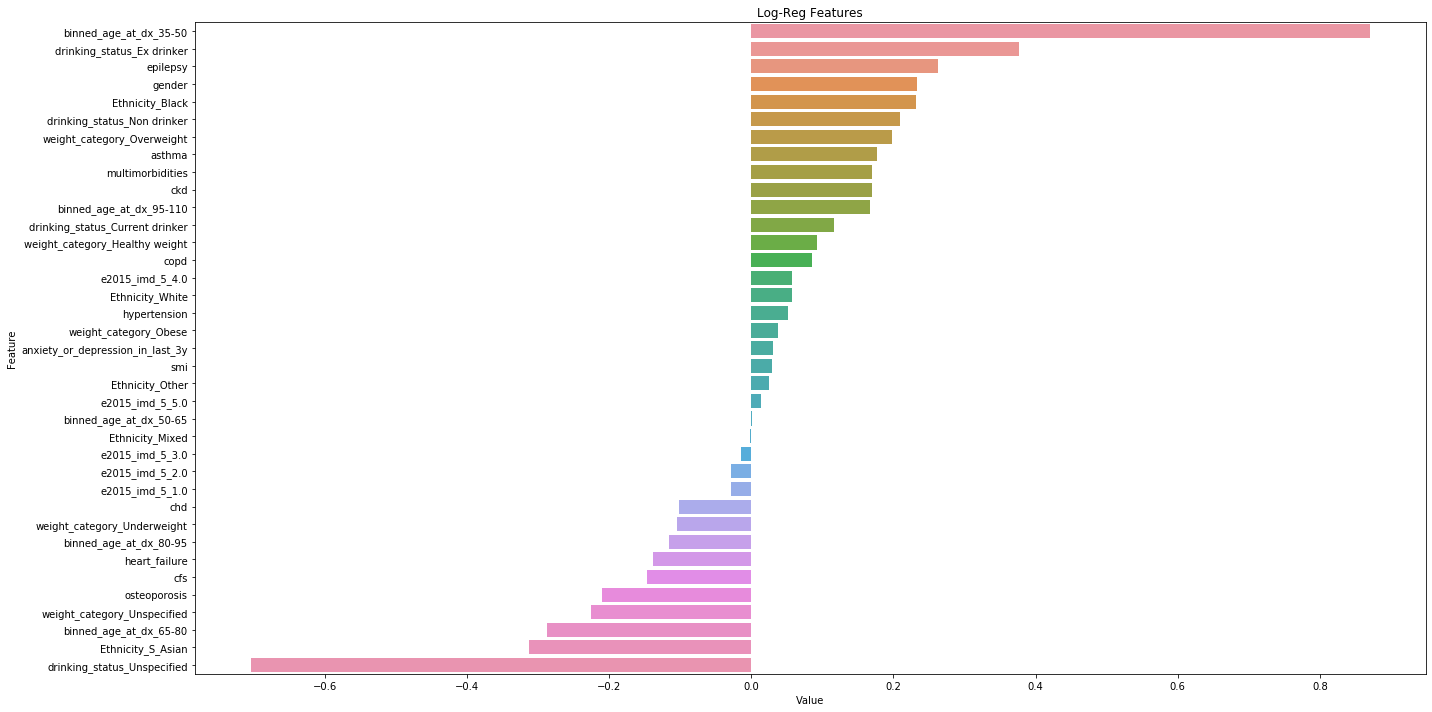

In [1402]:
# Get the names of each feature
feature_names = list(lr_pipeline.named_steps[
    "preprocessor"].named_transformers_[
    "onehot"].named_steps[
    "one_hot_encoder"].get_feature_names_out()) + supported_cols[num_cutoff:]
# Get the coefficients of each feature
feature_importances = grid_lr.best_estimator_.named_steps["classifier"].coef_[0]

feature_imp = pd.DataFrame(sorted(zip(feature_importances,feature_names)), columns=['Value','Feature']).sort_values(
    by="Value", ascending=False)

# plot and save plot for non practice id feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp[~feature_imp.Feature.str.contains('e_pracid')])
plt.title('Log-Reg Features')
plt.tight_layout()
plt.savefig(os.getcwd() + '/Analysis Outputs/Plot pngs' +
            f'/log-reg_{hes}_{pr_id}_{bin_age}_{sum_xm}_importances-rand_state{random_state}.png')
plt.show()

In [1403]:
# output csv for non practice id feature importances
feature_imp[~feature_imp.Feature.str.contains('e_pracid')].sort_values(by="Value", ascending=False)
feature_imp[~feature_imp.Feature.str.contains('e_pracid')].to_csv(
    os.getcwd() + '/Analysis Outputs/Importance csvs' +
    f'/log-reg_{hes}_{pr_id}_{bin_age}_{sum_xm}_importances-rand_state{random_state}.csv')

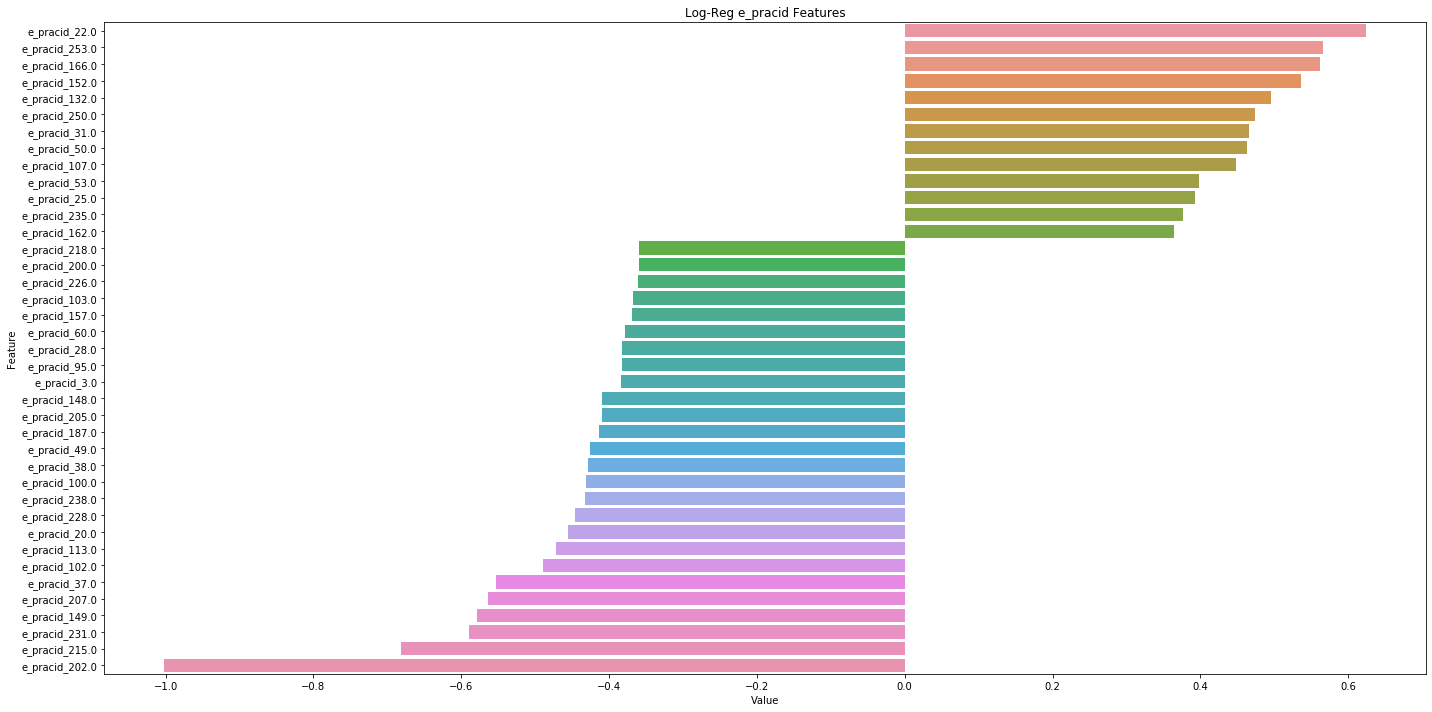

In [1404]:
# if selected plot and save plot for 5% edge cases for practice feature importance
# (as is directional, i.e. can be positive or negative, so is 10%)
if use_e_pracid:
    plt.figure(figsize=(20, 10))
    plot_data = feature_imp[feature_imp.Feature.str.contains('e_pracid')]
    plot_data = plot_data[abs(plot_data.Value) > plot_data.Value.quantile(.95)]
    sns.barplot(x="Value", y="Feature", data=plot_data)
    plt.title('Log-Reg e_pracid Features')
    plt.tight_layout()
    plt.savefig(os.getcwd() + '/Analysis Outputs/Plot pngs' +
                f'/log-reg_{hes}_{pr_id}_{bin_age}_{sum_xm}_e_pracid_importances-rand_state{random_state}.png')
    plt.show()

In [1405]:
# output all practice id feature importances if selected
if use_e_pracid:
    feature_imp[feature_imp.Feature.str.contains('e_pracid')].sort_values(by="Value", ascending=False)
    feature_imp[feature_imp.Feature.str.contains('e_pracid')].to_csv(
        os.getcwd() + '/Analysis Outputs/Importance csvs' +
        f'/log-reg_{hes}_{pr_id}_{bin_age}_{sum_xm}_e_pracid_importances-rand_state{random_state}.csv')